In [1]:
import pandas as pd 
import  numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf 
import  xml.etree.ElementTree as et 
import  cv2
import os 
import plotly.io as  px 
from glob import glob
from shutil import move,copy

In [2]:
from tensorflow.keras.preprocessing.image import  load_img,array_to_img,img_to_array
from sklearn.model_selection import  train_test_split

In [3]:
#  read the  annotatin file 
xml_path = glob('/kaggle/input/face-mask-detection/annotations/*.xml')
object_info = dict(filename =[],width=[],height=[],xmin =[],xmax=[],ymin=[],ymax=[],name=[])

for path in xml_path:
    
    parse = et.parse(path)
    root = parse.getroot()
    
    fname = root.find('filename').text
    
    size = root.find('size')
    width = size.find('width').text
    height = size.find('height').text
    object_all = root.findall('object')
    for obj in object_all:
        
        bbox_info = obj.find('bndbox')
        name = obj.find('name').text
        xmin = bbox_info.find('xmin').text
        xmax = bbox_info.find('xmax').text
        ymin = bbox_info.find('ymin').text
        ymax = bbox_info.find('ymax').text
        
        object_info['filename'].append(fname)
        object_info['width'].append(width)
        object_info['height'].append(height)
        object_info['xmin'].append(xmin)
        object_info['xmax'].append(xmax)
        object_info['ymin'].append(ymin)
        object_info['ymax'].append(ymax) 
        object_info['name'].append(name)
  

In [4]:
df = pd.DataFrame(object_info)
cols = ['width', 'height', 'xmin', 'xmax', 'ymin', 'ymax']
df[cols] = df[cols].astype('float32')
df.to_csv('labels.csv',index=False)
df.head()

filename  width  height   xmin   xmax  ymin  ymax  \
0  maksssksksss737.png  400.0   226.0   28.0   46.0  55.0  71.0   
1  maksssksksss737.png  400.0   226.0   98.0  111.0  62.0  78.0   
2  maksssksksss737.png  400.0   226.0  159.0  193.0  50.0  90.0   
3  maksssksksss737.png  400.0   226.0  293.0  313.0  59.0  80.0   
4  maksssksksss737.png  400.0   226.0  352.0  372.0  51.0  72.0   

                    name  
0              with_mask  
1              with_mask  
2  mask_weared_incorrect  
3              with_mask  
4              with_mask

In [5]:
df['cenetr_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])
df['W'] = (df['xmax'] - df['xmin'])/(df['width'])
df['H'] = (df['ymax'] - df['ymin'])/(df['height'])

In [6]:
source_code = { 'with_mask':0,
               'mask_weared_incorrect':1,
             'without_mask': 2
              }
df['id'] = df['name'].map(source_code)

In [7]:
file_df = pd.DataFrame(df['filename'].unique(),columns=['filename'])


In [8]:
train_df = tuple(file_df['filename'].sample(frac=0.8))
test_df = tuple(file_df.query(f"filename not in {train_df}")['filename'])

In [9]:
train_label = df.query(f"filename in {train_df}")

In [10]:
test_label = df.query(f"filename in {test_df}")

# save and laod image

In [11]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.9/921.9 kB 29.4 MB/s eta 0:00:00


In [12]:
!mkdir /kaggle/working/data_image/

In [13]:
!mkdir /kaggle/working/data_image/train/

In [14]:
!mkdir /kaggle/working/data_image/test/

In [15]:
cols = ['filename','id','cenetr_x', 'center_y', 'W', 'H']
train_groupby = train_label[cols].groupby('filename')
test_groupby = test_label[cols].groupby('filename')

In [16]:
train_folder = '/kaggle/working/data_image/train'
test_folder  = '/kaggle/working/data_image/test'

In [17]:
def save_data(filename,folder,groupby_data):
    scr = os.path.join('/kaggle/input/face-mask-detection/images',filename)
    dist = os.path.join(folder,filename)
    copy(scr,dist)

    text_name = os.path.join(folder,
                            os.path.splitext(filename)[0]+'.txt')
    groupby_data.get_group(filename).set_index('filename').to_csv(text_name,sep=' ',header=False,index=False)


In [18]:
train_series = pd.Series(train_groupby.groups.keys())
train_series.apply(save_data,args=(train_folder,train_groupby))

0      None
1      None
2      None
3      None
4      None
       ... 
677    None
678    None
679    None
680    None
681    None
Length: 682, dtype: object

In [19]:
test_series = pd.Series(test_groupby.groups.keys())
test_series.apply(save_data,args=(test_folder,test_groupby))

0      None
1      None
2      None
3      None
4      None
       ... 
166    None
167    None
168    None
169    None
170    None
Length: 171, dtype: object

In [20]:
#create a yaml file 
import yaml 
from yaml.loader import SafeLoader


In [21]:
data = """
train : /kaggle/working/data_image/train
val :  /kaggle/working/data_image/test
nc : 3 
names : [
        'with_mask',
        'mask_weared_incorrect',
        'without_mask'
        ]
"""
with open('data.yaml',mode ='w') as f :
    f.write(data)
    f.close()

In [22]:
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=a447ac4f95ba3b643291d64c4a0ee17762f8a749a987b7b615b865d9f559ca7c
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


In [23]:
import torch 
from numba import cuda 
from GPUtil import showUtilization as gpu_usage 
def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()  

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 10% |  2% |


In [24]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n.pt")

# Train the model
train_results = model.train(
    data="/kaggle/working/data.yaml",  
    epochs=200,  
    imgsz=640,
    batch = 15,
    cache=True,  
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 97.5MB/s]


Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/data.yaml, epochs=200, time=None, patience=100, batch=15, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

100%|██████████| 755k/755k [00:00<00:00, 46.4MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/data_image/train... 682 images, 0 backgrounds, 0 corrupt: 100%|██████████| 682/682 [00:01<00:00, 437.81it/s]

train: New cache created: /kaggle/working/data_image/train.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.5GB RAM): 100%|██████████| 682/682 [00:03<00:00, 181.97it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/data_image/test... 171 images, 0 backgrounds, 0 corrupt: 100%|██████████| 171/171 [00:00<00:00, 557.20it/s]

val: New cache created: /kaggle/working/data_image/test.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 171/171 [00:01<00:00, 166.71it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.00046875), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      2.48G      1.856      2.909      1.365         65        640: 100%|██████████| 46/46 [00:11<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]


                   all        171        874      0.879       0.22      0.248      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      2.34G      1.428      1.606      1.087         32        640: 100%|██████████| 46/46 [00:09<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.82it/s]

                   all        171        874      0.501      0.222      0.291      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      2.46G      1.348      1.467      1.068         43        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]

                   all        171        874      0.294      0.282      0.289      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      2.31G      1.317      1.301      1.046        101        640: 100%|██████████| 46/46 [00:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]

                   all        171        874      0.491      0.443      0.486      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      2.27G      1.267      1.213      1.037         41        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]

                   all        171        874      0.525       0.34      0.388      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      2.48G      1.259      1.156      1.039         44        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]

                   all        171        874       0.46      0.517      0.497      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      2.32G      1.228      1.066      1.026         61        640: 100%|██████████| 46/46 [00:09<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]

                   all        171        874      0.647      0.612       0.58      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      2.33G       1.19      1.023      1.014         34        640: 100%|██████████| 46/46 [00:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]

                   all        171        874      0.618      0.538      0.562      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200       2.5G      1.192     0.9698      1.014         60        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]

                   all        171        874      0.762      0.524      0.621      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      2.56G      1.222     0.9451      1.016         57        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.50it/s]

                   all        171        874      0.764      0.548      0.638       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      2.49G      1.181     0.9057      1.001         80        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.51it/s]

                   all        171        874      0.613      0.601       0.62      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      2.34G      1.133     0.8522     0.9911         59        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.46it/s]

                   all        171        874      0.648      0.594      0.605      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      2.34G      1.123     0.8209     0.9787         64        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]

                   all        171        874      0.714      0.594      0.647      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      2.31G      1.107     0.8267     0.9878         62        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.68it/s]

                   all        171        874      0.721      0.646      0.675      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200       2.3G      1.102     0.8012     0.9706         49        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.46it/s]

                   all        171        874      0.714      0.631      0.659       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      2.28G      1.093     0.7784     0.9771        105        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]

                   all        171        874      0.819      0.604      0.691      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      2.27G      1.093     0.7722     0.9805         57        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.60it/s]

                   all        171        874      0.683      0.589      0.659      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      2.44G      1.074      0.756     0.9751         59        640: 100%|██████████| 46/46 [00:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.66it/s]

                   all        171        874      0.702      0.623      0.669       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      2.29G       1.09     0.7445      0.986         61        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]

                   all        171        874      0.715      0.574      0.647      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      2.33G      1.065     0.7149     0.9675         51        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.66it/s]

                   all        171        874      0.763        0.6      0.675      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      2.38G      1.058     0.7031     0.9579         47        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.62it/s]

                   all        171        874      0.722       0.57       0.66      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      2.33G      1.036     0.6788     0.9589         43        640: 100%|██████████| 46/46 [00:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.79it/s]

                   all        171        874       0.87      0.601       0.69      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      2.43G      1.052     0.6984      0.964         76        640: 100%|██████████| 46/46 [00:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.67it/s]

                   all        171        874      0.772      0.647      0.709      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      2.46G      1.027     0.6697     0.9485         42        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.48it/s]

                   all        171        874      0.711      0.666      0.713       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      2.34G      1.024     0.6654     0.9518         81        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.41it/s]

                   all        171        874      0.737      0.677      0.702      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      2.57G      1.027     0.6652     0.9572         43        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.53it/s]

                   all        171        874      0.721      0.656      0.689      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      2.33G     0.9752      0.633     0.9358         51        640: 100%|██████████| 46/46 [00:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.59it/s]

                   all        171        874      0.691      0.707      0.701      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      2.34G      0.987       0.64     0.9495         30        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.64it/s]

                   all        171        874      0.797      0.621      0.704      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      2.27G      1.022     0.6518     0.9517         54        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.71it/s]

                   all        171        874      0.709      0.656      0.695      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      2.49G      1.008     0.6417       0.95         42        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.72it/s]

                   all        171        874      0.648      0.634      0.656      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      2.39G     0.9894      0.634     0.9429         38        640: 100%|██████████| 46/46 [00:09<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.53it/s]

                   all        171        874       0.68      0.672      0.681      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      2.31G      1.009     0.6477     0.9458         61        640: 100%|██████████| 46/46 [00:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.53it/s]

                   all        171        874       0.73      0.613      0.697      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      2.26G     0.9713     0.6181     0.9438         83        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.60it/s]

                   all        171        874      0.712       0.61      0.671      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      2.46G     0.9691     0.6089     0.9378         34        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.49it/s]

                   all        171        874      0.884      0.558      0.661      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200       2.5G     0.9511     0.6065     0.9325         40        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.76it/s]

                   all        171        874      0.724      0.611      0.695      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      2.54G     0.9732     0.6165      0.938         46        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.68it/s]

                   all        171        874      0.708      0.657      0.701      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200       2.7G     0.9566     0.6045     0.9325         79        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.65it/s]

                   all        171        874      0.755      0.654      0.732      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      2.33G     0.9535     0.5988     0.9321         49        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.65it/s]

                   all        171        874      0.736      0.699      0.732      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      2.31G     0.9422     0.5964     0.9327         57        640: 100%|██████████| 46/46 [00:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.65it/s]

                   all        171        874      0.813      0.636      0.726      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      2.31G     0.9209     0.5839     0.9282         99        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.73it/s]

                   all        171        874      0.762      0.663      0.743      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      2.31G     0.9166     0.5807     0.9254         27        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.73it/s]

                   all        171        874      0.896      0.659      0.747      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      2.31G     0.9392     0.5802     0.9312         71        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]

                   all        171        874      0.764      0.677      0.735      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      2.27G     0.9088      0.569     0.9204         46        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.66it/s]

                   all        171        874       0.79      0.648       0.73      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200       2.3G     0.8992     0.5629     0.9206         38        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.50it/s]

                   all        171        874      0.729      0.679      0.723      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      2.29G     0.9035     0.5684     0.9212         60        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.60it/s]

                   all        171        874      0.854      0.668      0.749      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      2.51G     0.8994     0.5547     0.9156         48        640: 100%|██████████| 46/46 [00:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.65it/s]

                   all        171        874      0.708      0.655       0.69      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      2.29G      0.913     0.5655     0.9236         77        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.78it/s]

                   all        171        874      0.811      0.614       0.73      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      2.56G      0.882     0.5395     0.9115         59        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.64it/s]

                   all        171        874      0.811      0.626      0.716      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      2.45G     0.8805     0.5443     0.9154         60        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.89it/s]

                   all        171        874      0.812      0.652      0.724       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      2.34G     0.8835     0.5433     0.9042         56        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.87it/s]

                   all        171        874      0.809      0.719      0.764      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      2.33G     0.8716     0.5505     0.9142         46        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.84it/s]

                   all        171        874      0.784      0.721      0.748      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200       2.3G     0.8662      0.521     0.9065         54        640: 100%|██████████| 46/46 [00:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.75it/s]

                   all        171        874      0.842      0.616      0.707      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      2.33G     0.8872     0.5396     0.9101         81        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.92it/s]

                   all        171        874       0.83      0.626      0.701      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      2.31G     0.8567     0.5255     0.9074         54        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.65it/s]

                   all        171        874      0.683      0.684        0.7      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200       2.5G     0.8625     0.5351     0.9085         40        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.90it/s]

                   all        171        874      0.871      0.648      0.746      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      2.27G     0.8847     0.5526     0.9066         53        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.56it/s]

                   all        171        874      0.755      0.624      0.689      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      2.27G     0.8517     0.5261     0.9031         50        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.67it/s]

                   all        171        874      0.734      0.663       0.71       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      2.33G     0.8674     0.5271     0.9098         39        640: 100%|██████████| 46/46 [00:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.84it/s]

                   all        171        874      0.881      0.653      0.754      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200       2.5G     0.8441     0.5262     0.9021         81        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.70it/s]

                   all        171        874      0.803       0.58      0.687      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      2.39G     0.8703      0.529     0.9102         64        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.62it/s]

                   all        171        874      0.862      0.624      0.743      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      2.63G      0.855      0.518     0.9027         43        640: 100%|██████████| 46/46 [00:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.56it/s]

                   all        171        874      0.811      0.641      0.708      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      2.31G     0.8309     0.5017     0.9019         44        640: 100%|██████████| 46/46 [00:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.78it/s]

                   all        171        874      0.867      0.645      0.746      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      2.58G      0.851      0.522     0.9109         72        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.75it/s]

                   all        171        874      0.851       0.66      0.757      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      2.33G     0.8304     0.4992     0.9044         57        640: 100%|██████████| 46/46 [00:09<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.65it/s]

                   all        171        874       0.82      0.687      0.751      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      2.35G     0.8189      0.492     0.8947         37        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.76it/s]

                   all        171        874      0.807      0.594      0.694      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      2.29G     0.8414     0.5197        0.9         62        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.55it/s]

                   all        171        874      0.848      0.608      0.727      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      2.28G     0.8312     0.4989     0.8934         50        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.75it/s]

                   all        171        874      0.741      0.619      0.702      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      2.33G     0.8212     0.4962     0.8958         61        640: 100%|██████████| 46/46 [00:09<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.41it/s]

                   all        171        874      0.794      0.653      0.739      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      2.32G     0.8395     0.5026     0.8991         27        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.73it/s]

                   all        171        874      0.834      0.673      0.743      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      2.52G     0.8228     0.4895     0.8994         57        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.64it/s]

                   all        171        874      0.856      0.635      0.741      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200       2.5G     0.7959     0.4805     0.8935         37        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]

                   all        171        874      0.717      0.694       0.73      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      2.26G     0.8082     0.4911      0.899         82        640: 100%|██████████| 46/46 [00:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.80it/s]

                   all        171        874      0.731      0.673      0.701      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      2.31G     0.8043     0.4964     0.8948         59        640: 100%|██████████| 46/46 [00:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.57it/s]

                   all        171        874      0.777      0.682      0.726      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      2.31G     0.8012     0.4965     0.8899         36        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.78it/s]

                   all        171        874      0.773      0.673      0.731      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      2.71G     0.7999     0.4847     0.8949         39        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.77it/s]

                   all        171        874      0.747      0.674      0.721      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      2.31G     0.7984     0.4859     0.8962         60        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.91it/s]

                   all        171        874      0.815      0.688      0.741      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      2.51G     0.8062     0.4847       0.89         46        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.56it/s]

                   all        171        874      0.909      0.659      0.756      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      2.32G     0.7809      0.474     0.8847         93        640: 100%|██████████| 46/46 [00:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.70it/s]

                   all        171        874      0.738      0.676      0.724      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      2.27G     0.7801     0.4688     0.8908         16        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.88it/s]

                   all        171        874      0.827      0.631      0.706      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200       2.3G     0.7804     0.4731      0.887         76        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.85it/s]

                   all        171        874      0.853      0.623      0.735      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200       2.5G     0.7628     0.4648     0.8851         57        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.85it/s]

                   all        171        874      0.777      0.703       0.75      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      2.47G     0.7847     0.4799     0.8917         22        640: 100%|██████████| 46/46 [00:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.74it/s]

                   all        171        874      0.852      0.657      0.752      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      2.52G     0.7782      0.474     0.8873         36        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.71it/s]

                   all        171        874      0.718      0.662      0.731      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      2.31G     0.7755     0.4692     0.8866         35        640: 100%|██████████| 46/46 [00:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.84it/s]

                   all        171        874      0.752      0.707      0.718      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      2.54G     0.7874     0.4736     0.8864         68        640: 100%|██████████| 46/46 [00:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.80it/s]

                   all        171        874      0.906      0.634      0.731      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200       2.5G     0.7589     0.4596     0.8844         31        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.73it/s]

                   all        171        874      0.922      0.639      0.736      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200       2.3G     0.7365      0.455     0.8823         48        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]

                   all        171        874       0.75      0.731      0.757      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200       2.3G     0.7501      0.455     0.8767         34        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]

                   all        171        874      0.881      0.649      0.767      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      2.43G     0.7649     0.4588     0.8817         72        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.80it/s]

                   all        171        874       0.75      0.658      0.709      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      2.31G     0.7552     0.4606     0.8788         28        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.69it/s]

                   all        171        874      0.766      0.707      0.771      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      2.32G     0.7388     0.4483     0.8754         92        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.72it/s]

                   all        171        874      0.814      0.719       0.77      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200       2.3G     0.7394     0.4476     0.8817         59        640: 100%|██████████| 46/46 [00:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.89it/s]

                   all        171        874      0.871      0.685      0.778      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      2.55G     0.7363     0.4479     0.8774         25        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.78it/s]

                   all        171        874      0.869      0.704      0.763      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      2.49G     0.7507     0.4526      0.875         30        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.81it/s]

                   all        171        874      0.857      0.672       0.76      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200       2.3G     0.7268     0.4352     0.8691         54        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.69it/s]

                   all        171        874      0.831      0.676      0.752      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      2.33G     0.7293     0.4408     0.8763         82        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]

                   all        171        874      0.909      0.676      0.771      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      2.54G     0.7287     0.4403     0.8744         52        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.78it/s]

                   all        171        874       0.77       0.67       0.74      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      2.74G     0.7378     0.4356       0.87         85        640: 100%|██████████| 46/46 [00:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]

                   all        171        874      0.808      0.694      0.751      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      2.26G     0.7401      0.443     0.8787         98        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.79it/s]

                   all        171        874      0.832      0.666      0.765       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200       2.3G     0.7409     0.4439     0.8806         54        640: 100%|██████████| 46/46 [00:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.55it/s]

                   all        171        874      0.784      0.696      0.755      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      2.32G      0.726     0.4382     0.8746         61        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.57it/s]

                   all        171        874      0.799       0.66      0.753      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      2.71G     0.7172     0.4415     0.8688         46        640: 100%|██████████| 46/46 [00:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.71it/s]

                   all        171        874       0.87      0.658      0.757      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200       2.3G     0.7178     0.4402     0.8715         39        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.99it/s]

                   all        171        874      0.782      0.676      0.739      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      2.31G     0.7072      0.431      0.872         79        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.53it/s]

                   all        171        874      0.857      0.663      0.762      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      2.31G     0.7118     0.4372     0.8713         36        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.81it/s]

                   all        171        874      0.752      0.678      0.735      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      2.45G      0.694     0.4237     0.8664         26        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.77it/s]

                   all        171        874      0.779      0.696      0.751      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      2.31G     0.6791      0.407     0.8679         51        640: 100%|██████████| 46/46 [00:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.67it/s]

                   all        171        874      0.921      0.671      0.767      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      2.56G     0.7215     0.4338     0.8706         76        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.77it/s]

                   all        171        874      0.868        0.7      0.781      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200       2.3G     0.6804     0.4126     0.8688         48        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.64it/s]

                   all        171        874      0.826      0.717      0.783      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      2.45G      0.695     0.4133     0.8674         67        640: 100%|██████████| 46/46 [00:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.95it/s]

                   all        171        874      0.854      0.717      0.778      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      2.47G     0.6859     0.4196     0.8612         66        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]

                   all        171        874      0.833      0.683      0.759      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      2.46G     0.6795     0.4112     0.8588         15        640: 100%|██████████| 46/46 [00:09<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.81it/s]

                   all        171        874      0.865      0.674      0.747      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      2.44G     0.6989      0.422     0.8664         65        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.94it/s]

                   all        171        874      0.816      0.692      0.758      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      2.31G     0.6815     0.4153     0.8621         66        640: 100%|██████████| 46/46 [00:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.66it/s]

                   all        171        874      0.799      0.659      0.755      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200       2.3G     0.6748      0.408     0.8653         48        640: 100%|██████████| 46/46 [00:09<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]

                   all        171        874      0.869      0.631      0.743      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200       2.3G     0.6831     0.4194     0.8656         32        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.70it/s]

                   all        171        874      0.845      0.669       0.76      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      2.27G     0.6974     0.4189     0.8691         79        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.87it/s]

                   all        171        874      0.775       0.67       0.74      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      2.44G     0.6951     0.4151     0.8668         60        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.76it/s]

                   all        171        874      0.791      0.678      0.736      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200       2.3G     0.6735     0.4059     0.8608         58        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.90it/s]

                   all        171        874      0.849      0.627      0.746      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200       2.3G      0.685     0.4125     0.8671         79        640: 100%|██████████| 46/46 [00:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.78it/s]

                   all        171        874       0.83      0.651      0.758      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      2.43G     0.6559     0.4058     0.8592         71        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.79it/s]

                   all        171        874      0.754      0.716      0.759      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      2.53G     0.6775     0.4091     0.8589         47        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.68it/s]

                   all        171        874      0.895       0.65      0.776      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      2.68G     0.6493     0.3982     0.8544         33        640: 100%|██████████| 46/46 [00:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.92it/s]

                   all        171        874      0.737      0.748      0.763      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200       2.3G      0.672     0.4098      0.867         73        640: 100%|██████████| 46/46 [00:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.59it/s]

                   all        171        874      0.827       0.71      0.763      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200       2.4G     0.6722     0.4049     0.8662         42        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.67it/s]

                   all        171        874       0.83       0.68      0.768      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      2.53G     0.6834     0.4059     0.8573         84        640: 100%|██████████| 46/46 [00:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.56it/s]

                   all        171        874      0.901      0.638      0.763      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200       2.3G     0.6596     0.3936     0.8595         37        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.81it/s]

                   all        171        874      0.806      0.742      0.785      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      2.44G     0.6559     0.3987     0.8578         45        640: 100%|██████████| 46/46 [00:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.76it/s]

                   all        171        874      0.779      0.719       0.77      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      2.47G     0.6488     0.3961     0.8605         31        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]

                   all        171        874      0.906      0.657      0.775      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      2.31G     0.6665      0.404     0.8623         38        640: 100%|██████████| 46/46 [00:09<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.68it/s]

                   all        171        874      0.798      0.682      0.754      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      2.36G     0.6628     0.4031     0.8656         73        640: 100%|██████████| 46/46 [00:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.85it/s]

                   all        171        874      0.865      0.676      0.773      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      2.43G     0.6539     0.3997      0.858         70        640: 100%|██████████| 46/46 [00:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]

                   all        171        874      0.859      0.653      0.747      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      2.31G     0.6678     0.4041     0.8666         55        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.47it/s]

                   all        171        874       0.86      0.696       0.78      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      2.29G     0.6434      0.388     0.8539         67        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.66it/s]

                   all        171        874      0.874      0.676      0.768      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      2.28G     0.6415     0.3844     0.8589         64        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.61it/s]

                   all        171        874      0.854      0.676      0.766      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      2.46G     0.6348     0.3776      0.854         30        640: 100%|██████████| 46/46 [00:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]

                   all        171        874       0.81      0.701      0.779      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      2.32G     0.6468     0.3851      0.862         64        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.75it/s]

                   all        171        874      0.826      0.692       0.76      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      2.51G     0.6645     0.3957      0.857         61        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.71it/s]

                   all        171        874      0.874      0.681      0.781      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      2.28G     0.6411     0.3885     0.8542        110        640: 100%|██████████| 46/46 [00:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.96it/s]

                   all        171        874      0.885      0.635      0.754      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      2.31G     0.6309     0.3835     0.8585         42        640: 100%|██████████| 46/46 [00:09<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.93it/s]

                   all        171        874      0.897      0.685       0.79      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      2.69G     0.6316     0.3808     0.8536         41        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.82it/s]

                   all        171        874      0.851      0.727      0.807      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      2.31G      0.626      0.376     0.8546         73        640: 100%|██████████| 46/46 [00:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]

                   all        171        874       0.89      0.673      0.794      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      2.44G      0.627     0.3767     0.8501         77        640: 100%|██████████| 46/46 [00:09<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.70it/s]

                   all        171        874      0.762      0.736      0.786       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      2.32G     0.6231     0.3743     0.8513         36        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.91it/s]

                   all        171        874       0.86      0.718      0.795      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200       2.3G     0.6223     0.3707     0.8489         41        640: 100%|██████████| 46/46 [00:09<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.87it/s]

                   all        171        874      0.821      0.712      0.779      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      2.54G     0.6131     0.3785     0.8431         69        640: 100%|██████████| 46/46 [00:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.87it/s]

                   all        171        874      0.825      0.671      0.775      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      2.54G      0.625     0.3683     0.8519        101        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.71it/s]

                   all        171        874      0.835      0.664      0.765      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200       2.3G     0.6195     0.3735     0.8519         65        640: 100%|██████████| 46/46 [00:09<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.91it/s]

                   all        171        874      0.816      0.703      0.768      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      2.33G     0.6252     0.3727     0.8508         51        640: 100%|██████████| 46/46 [00:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.71it/s]

                   all        171        874      0.835      0.702      0.772      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200       2.3G     0.6238     0.3784     0.8511         71        640: 100%|██████████| 46/46 [00:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.76it/s]

                   all        171        874      0.813      0.712      0.768      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      2.33G     0.6072     0.3681     0.8468         54        640: 100%|██████████| 46/46 [00:09<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.92it/s]

                   all        171        874       0.92      0.663      0.756      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      2.32G     0.6243     0.3771      0.849         21        640: 100%|██████████| 46/46 [00:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.97it/s]

                   all        171        874      0.869       0.66      0.775      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      2.48G     0.6073     0.3699     0.8462         37        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.85it/s]

                   all        171        874      0.876       0.68      0.774      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      2.44G     0.6251      0.369     0.8527         65        640: 100%|██████████| 46/46 [00:09<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.93it/s]

                   all        171        874      0.895      0.673      0.767      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      2.33G     0.6111     0.3681      0.848         34        640: 100%|██████████| 46/46 [00:09<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.82it/s]

                   all        171        874      0.832      0.683      0.763      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      2.51G     0.5987     0.3699     0.8427         50        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.93it/s]

                   all        171        874       0.83      0.705      0.777      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200       2.3G     0.6029     0.3646     0.8436         56        640: 100%|██████████| 46/46 [00:09<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.91it/s]

                   all        171        874      0.909      0.671       0.77      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      2.49G      0.586     0.3574     0.8447         34        640: 100%|██████████| 46/46 [00:09<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.82it/s]

                   all        171        874       0.86      0.678      0.761      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      2.52G     0.5892     0.3564     0.8431         27        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.53it/s]

                   all        171        874      0.855      0.698      0.787      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      2.33G     0.6045     0.3662     0.8449         72        640: 100%|██████████| 46/46 [00:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.67it/s]

                   all        171        874      0.869      0.711      0.785      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      2.45G     0.5802     0.3532     0.8455         71        640: 100%|██████████| 46/46 [00:09<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.79it/s]

                   all        171        874      0.879      0.692      0.783      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      2.53G     0.5817     0.3532     0.8459         56        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.81it/s]

                   all        171        874      0.856      0.683      0.773      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      2.31G     0.6009     0.3565     0.8491         35        640: 100%|██████████| 46/46 [00:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.97it/s]

                   all        171        874      0.922      0.647      0.782       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200       2.3G     0.5827     0.3509     0.8442         55        640: 100%|██████████| 46/46 [00:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]

                   all        171        874      0.889      0.685      0.785      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200       2.3G     0.5729     0.3454     0.8398         62        640: 100%|██████████| 46/46 [00:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.80it/s]

                   all        171        874      0.836      0.718      0.792      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      2.47G     0.5881      0.358     0.8463         43        640: 100%|██████████| 46/46 [00:09<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.69it/s]

                   all        171        874      0.811      0.734        0.8       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      2.32G     0.5862     0.3534     0.8447         56        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.42it/s]

                   all        171        874      0.839      0.731      0.792      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      2.52G     0.5939      0.358     0.8462         73        640: 100%|██████████| 46/46 [00:09<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.88it/s]

                   all        171        874      0.845      0.693      0.777       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      2.49G     0.5935     0.3561     0.8422         97        640: 100%|██████████| 46/46 [00:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.91it/s]

                   all        171        874      0.732      0.754      0.786      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      2.47G     0.5757      0.343     0.8478         67        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.77it/s]

                   all        171        874        0.8      0.723      0.791      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      2.47G      0.586      0.349     0.8387         32        640: 100%|██████████| 46/46 [00:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.98it/s]

                   all        171        874      0.804      0.734      0.787      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      2.32G     0.5808     0.3475     0.8453         94        640: 100%|██████████| 46/46 [00:09<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.77it/s]

                   all        171        874      0.848      0.704      0.784      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      2.51G     0.5561     0.3368     0.8383         57        640: 100%|██████████| 46/46 [00:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.88it/s]

                   all        171        874      0.811      0.726      0.781      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      2.32G     0.5824     0.3495     0.8412         59        640: 100%|██████████| 46/46 [00:09<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.75it/s]

                   all        171        874      0.845      0.715      0.791      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      2.54G     0.5733     0.3495     0.8444         76        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.89it/s]

                   all        171        874       0.88        0.7      0.789      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      2.32G     0.5804     0.3517     0.8417         49        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.88it/s]

                   all        171        874      0.828      0.709       0.78      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      2.54G     0.5664     0.3422     0.8421         46        640: 100%|██████████| 46/46 [00:09<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.98it/s]

                   all        171        874      0.817      0.707      0.775      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      2.32G     0.5739     0.3448     0.8408         38        640: 100%|██████████| 46/46 [00:09<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.91it/s]

                   all        171        874      0.795      0.703      0.776      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      2.48G     0.5614     0.3422     0.8358         70        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.66it/s]

                   all        171        874      0.807      0.712      0.775      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      2.53G      0.565     0.3395     0.8385         64        640: 100%|██████████| 46/46 [00:09<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.81it/s]

                   all        171        874      0.818      0.711      0.779      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      2.27G     0.5545     0.3309      0.838         52        640: 100%|██████████| 46/46 [00:09<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.98it/s]

                   all        171        874       0.82      0.711      0.766      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      2.45G      0.556     0.3352     0.8405         48        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.59it/s]

                   all        171        874      0.795      0.732      0.777      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      2.33G     0.5337     0.3268     0.8364         38        640: 100%|██████████| 46/46 [00:09<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.81it/s]

                   all        171        874      0.772      0.746      0.778      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      2.42G     0.5711     0.3453     0.8438         37        640: 100%|██████████| 46/46 [00:09<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.85it/s]

                   all        171        874      0.859      0.683      0.784      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      2.51G     0.5703     0.3403     0.8454         43        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.00it/s]

                   all        171        874      0.832      0.707      0.786      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      2.32G     0.5537     0.3333     0.8337         36        640: 100%|██████████| 46/46 [00:09<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.84it/s]

                   all        171        874      0.809      0.739      0.784      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      2.34G     0.5501     0.3287     0.8376         96        640: 100%|██████████| 46/46 [00:09<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.73it/s]

                   all        171        874      0.792      0.741      0.787      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      2.31G     0.5558     0.3331     0.8315         68        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.89it/s]

                   all        171        874      0.835      0.717       0.79      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200       2.3G     0.5365     0.3255     0.8387         50        640: 100%|██████████| 46/46 [00:09<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.11it/s]

                   all        171        874      0.844      0.702      0.793      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      2.32G     0.5391     0.3305     0.8342         55        640: 100%|██████████| 46/46 [00:09<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.88it/s]

                   all        171        874      0.808       0.74      0.793      0.529


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      2.64G     0.9207     0.4678     0.9372         26        640: 100%|██████████| 46/46 [00:09<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.80it/s]

                   all        171        874      0.893      0.688      0.789      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      2.61G     0.9014     0.4617     0.9313         15        640: 100%|██████████| 46/46 [00:09<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.61it/s]

                   all        171        874      0.893      0.667      0.785      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      2.65G     0.8971     0.4454     0.9279         17        640: 100%|██████████| 46/46 [00:09<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.89it/s]

                   all        171        874      0.844      0.697      0.791      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      2.48G      0.883     0.4399     0.9141         28        640: 100%|██████████| 46/46 [00:09<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.79it/s]

                   all        171        874      0.756      0.763      0.804      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200       2.5G     0.8749     0.4359     0.9158         16        640: 100%|██████████| 46/46 [00:09<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.92it/s]

                   all        171        874      0.868        0.7      0.801      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      2.48G     0.8769     0.4314     0.9172         25        640: 100%|██████████| 46/46 [00:09<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.94it/s]

                   all        171        874      0.884      0.699        0.8       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      2.51G     0.8746     0.4435     0.9117         18        640: 100%|██████████| 46/46 [00:09<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.82it/s]

                   all        171        874      0.821      0.724      0.803      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      2.52G     0.8658     0.4368     0.9057         50        640: 100%|██████████| 46/46 [00:09<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.70it/s]

                   all        171        874      0.864      0.712      0.806      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      2.65G     0.8543     0.4279     0.9128         20        640: 100%|██████████| 46/46 [00:09<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.88it/s]

                   all        171        874      0.856      0.724      0.802      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      2.47G     0.8609     0.4201     0.9081         36        640: 100%|██████████| 46/46 [00:09<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.56it/s]

                   all        171        874      0.857      0.707      0.804      0.542



200 epochs completed in 0.614 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.33it/s]


                   all        171        874      0.862      0.711      0.806      0.545
             with_mask        152        644      0.925      0.885      0.926      0.636
 mask_weared_incorrect         21         30      0.821      0.567      0.705      0.491
          without_mask         60        200      0.841       0.68      0.786      0.508


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train


In [25]:
store = model.export(format="onnx") 

Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.00GHz)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.9/142.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 121.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 210.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 312.3 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 12.4s, installed 2 packages: ['onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.48...
O

In [26]:
!pip install openvino

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 MB 16.9 MB/s eta 0:00:0000:0100:01m


In [27]:
store = model.export(format="openvino") # for inferrence

Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.00GHz)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (5.2 MB)
requirements: Ultralytics requirement ['openvino>=2024.0.0,<2025.0.0'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 MB 67.9 MB/s eta 0:00:00
  Attempting uninstall: openvino
    Found existing installation: openvino 2025.0.0
    Uninstalling openvino-2025.0.0:
      Successfully uninstalled openvino-2025.0.0

requirements: AutoUpdate success ✅ 5.2s, installed 1 package: ['openvino>=2024.0.0,<2025.0.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


OpenVINO: starting export with openvino 2024.6.0-17404-4c0f47d2335-releases/2024/6...
OpenVINO: export success ✅ 10.2s, saved as 'runs/detect/train/weights/best_openvi

Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/working/data_image/test.cache... 171 images, 0 backgrounds, 0 corrupt: 100%|██████████| 171/171 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 171/171 [00:00<00:00, 187.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.13it/s]


                   all        171        874      0.863      0.711      0.804      0.546
             with_mask        152        644      0.922       0.88      0.923      0.638
 mask_weared_incorrect         21         30      0.822      0.567      0.704      0.491
          without_mask         60        200      0.846      0.685      0.784       0.51


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.0ms preprocess, 9.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train2

image 1/1 /kaggle/input/face-mask-detection/images/maksssksksss107.png: 640x512 1 with_mask, 43.6ms
Speed: 2.7ms preprocess, 43.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


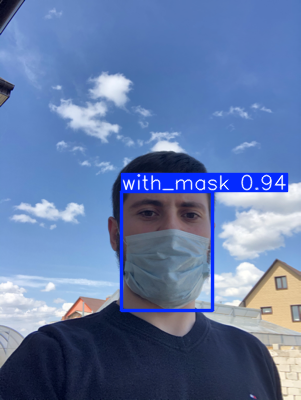

In [28]:
metrics = model.val()

# Perform object detection on an image
results = model("/kaggle/input/face-mask-detection/images/maksssksksss107.png")
results[0].show()

# Evaluate our model

In [29]:
metrics = model.val(split='val')

print(f"Mean Average Precision  : {metrics.box.map}")    
print(f"Mean Average Precision   : {metrics.box.map50}") 
print(f"Mean Average Precision    : {metrics.box.map75}")
print("recall : ",metrics.box.r)
print(metrics.box.f1)
print(metrics.box.maps)

metrics_df = pd.DataFrame.from_dict(metrics.results_dict, orient='index', columns=['Metric Value'])

metrics_df.round(3)

Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


val: Scanning /kaggle/working/data_image/test.cache... 171 images, 0 backgrounds, 0 corrupt: 100%|██████████| 171/171 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 171/171 [00:00<00:00, 174.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.91it/s]


                   all        171        874      0.863      0.711      0.804      0.546
             with_mask        152        644      0.922       0.88      0.923      0.638
 mask_weared_incorrect         21         30      0.822      0.567      0.704      0.491
          without_mask         60        200      0.846      0.685      0.784       0.51


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.3ms preprocess, 4.7ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/train3
Mean Average Precision  : 0.5460002597909803
Mean Average Precision   : 0.8036279946105883
Mean Average Precision    : 0.6432855053444223
recall :  [    0.88043     0.56667     0.68477]
[    0.90085     0.67084     0.75675]
[    0.63774      0.4905     0.50976]


Metric Value
metrics/precision(B)         0.863
metrics/recall(B)            0.711
metrics/mAP50(B)             0.804
metrics/mAP50-95(B)          0.546
fitness                      0.572

(-0.5, 2249.5, 1499.5, -0.5)

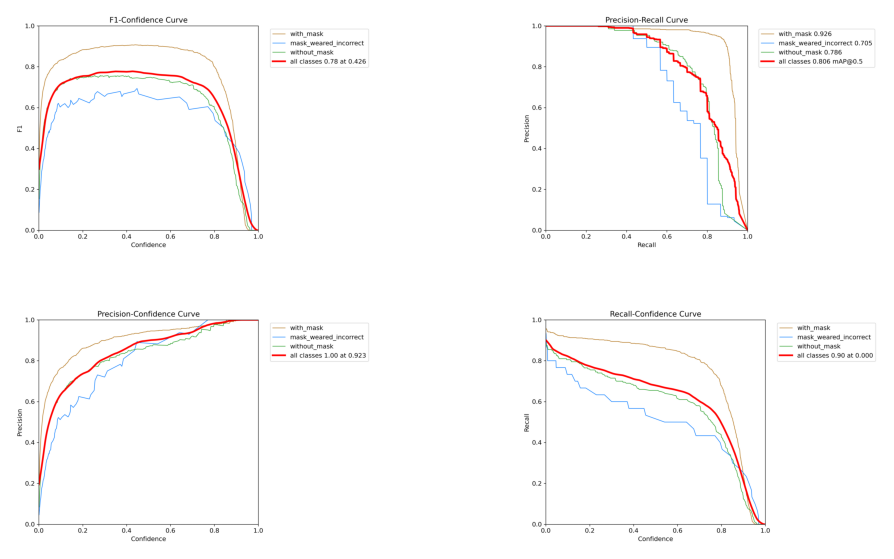

In [30]:
plt.figure(figsize=(12,7))

plt.subplot(221)
F1_curve = cv2.imread('/kaggle/working/runs/detect/train/F1_curve.png')
plt.imshow(F1_curve)
plt.axis('off')
plt.subplot(222)
PR_curve = cv2.imread('/kaggle/working/runs/detect/train/PR_curve.png')
plt.imshow(PR_curve)
plt.axis('off')
plt.subplot(223)
P_curve = cv2.imread('/kaggle/working/runs/detect/train/P_curve.png')
plt.imshow(P_curve)
plt.axis('off')
plt.subplot(224)
R_curve = cv2.imread('/kaggle/working/runs/detect/train/R_curve.png')
plt.imshow(R_curve)
plt.axis('off')

(-0.5, 2399.5, 1199.5, -0.5)

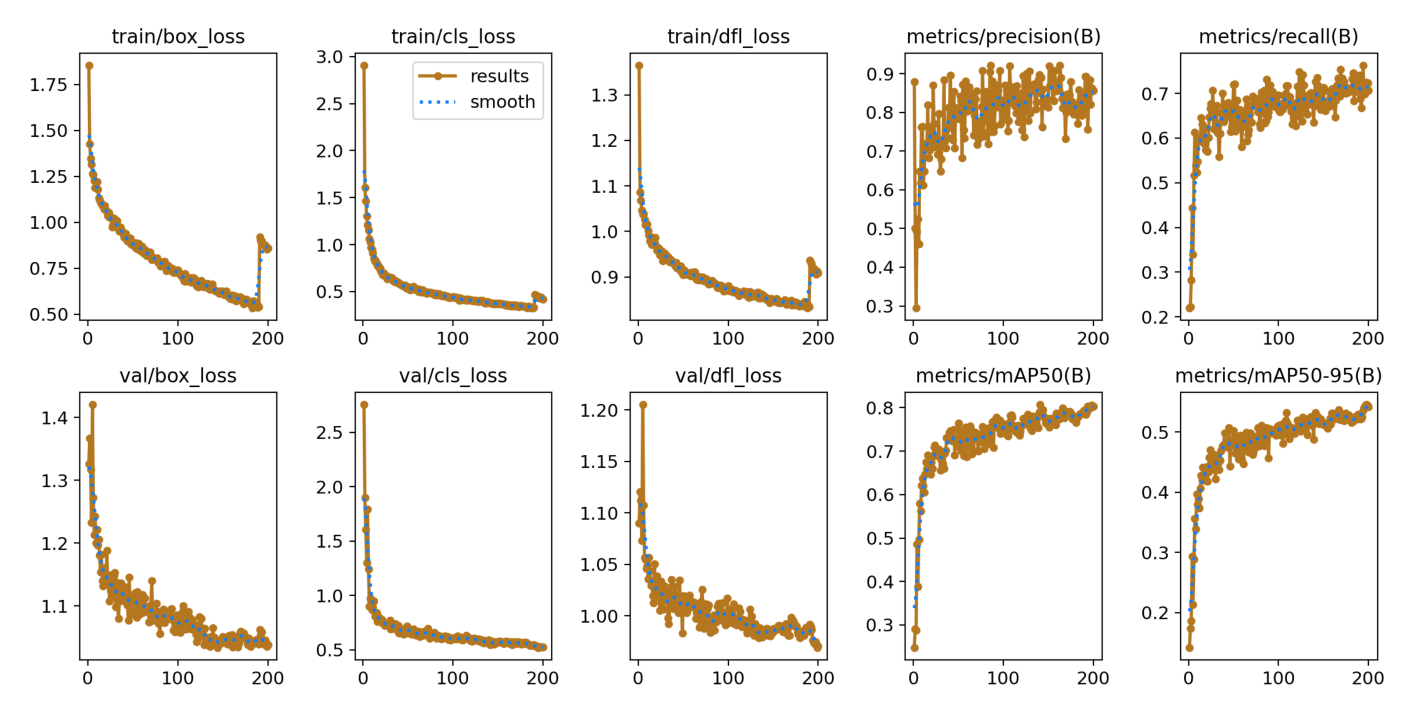

In [31]:
plt.figure(figsize=(18,18))
img = cv2.imread('/kaggle/working/runs/detect/train/results.png')
plt.imshow(img)
plt.axis('off')

(-0.5, 2999.5, 2249.5, -0.5)

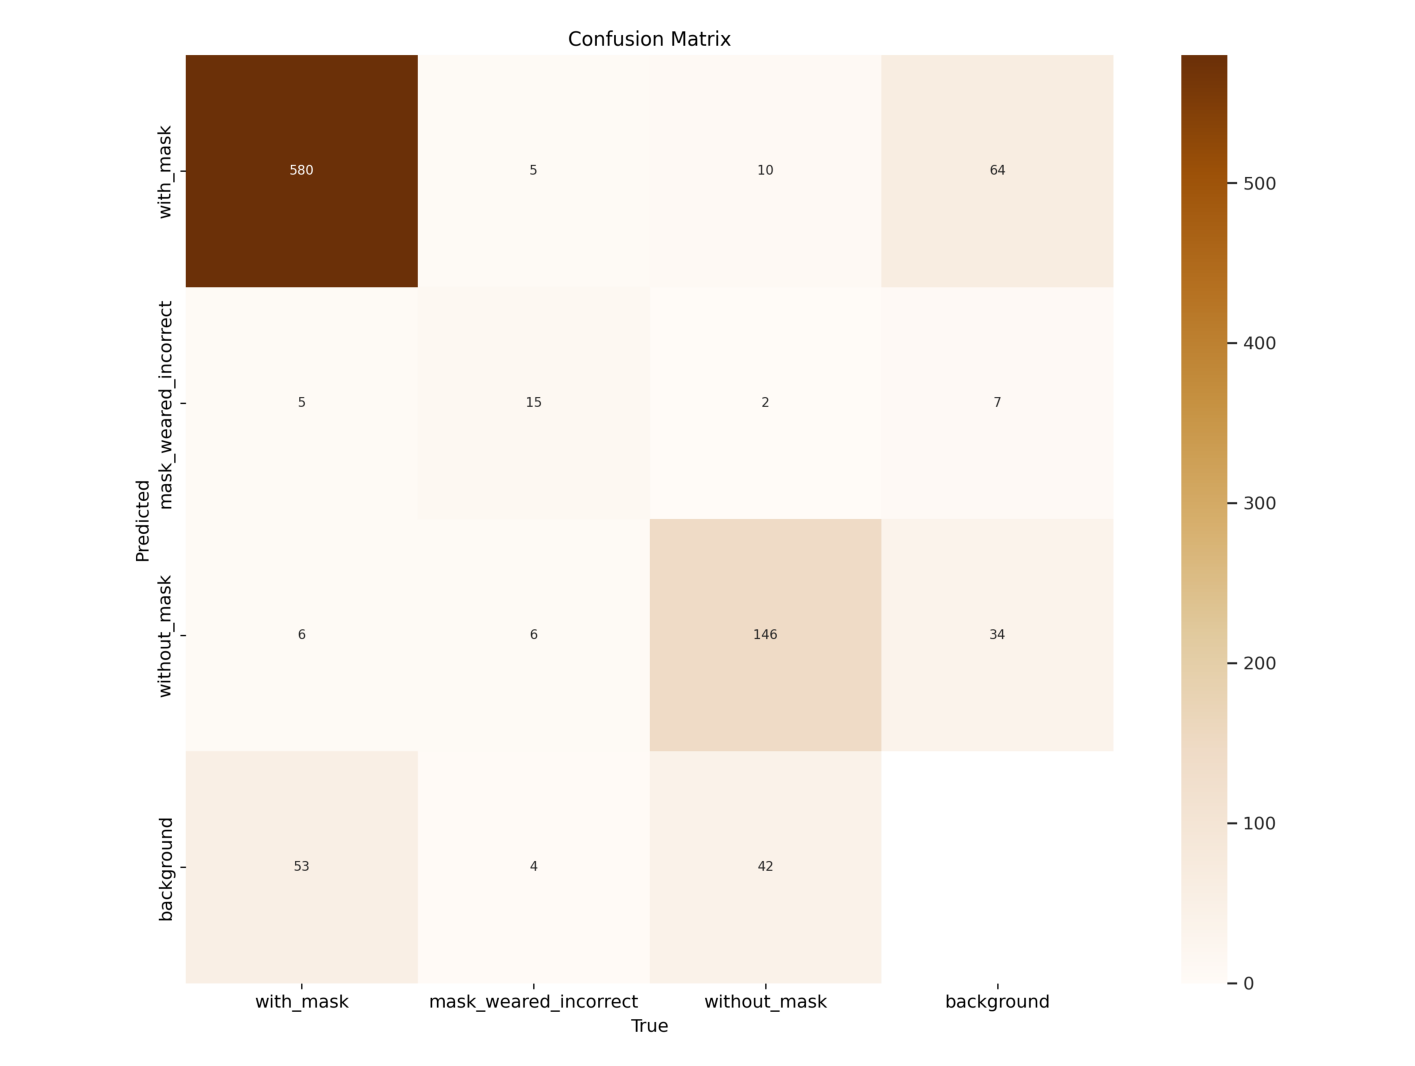

In [32]:
plt.figure(figsize=(18,18))
confusion_matrix = cv2.imread('/kaggle/working/runs/detect/train/confusion_matrix.png')
plt.imshow(confusion_matrix)
plt.axis('off')

(-0.5, 1919.5, 1279.5, -0.5)

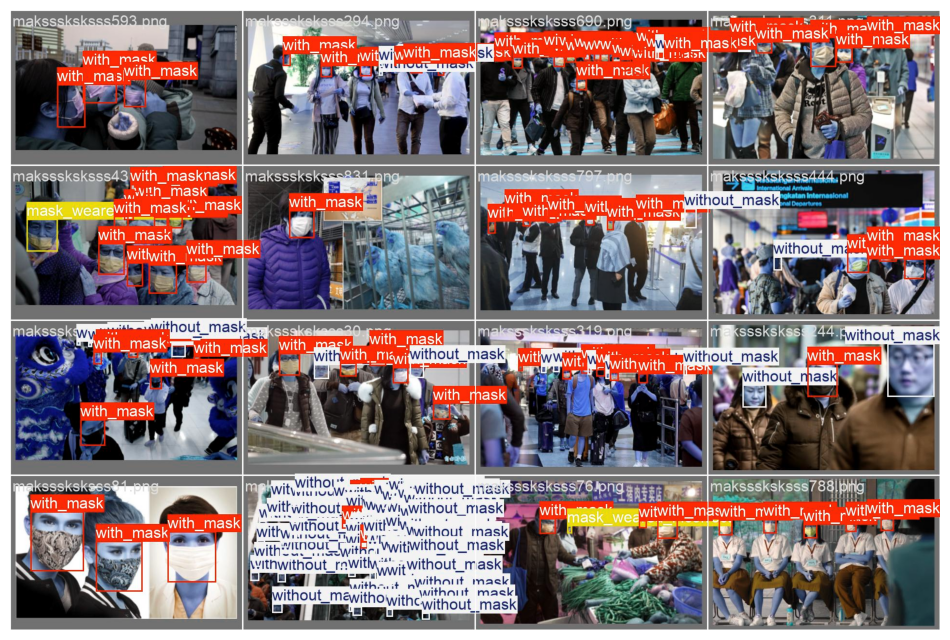

In [33]:
plt.figure(figsize=(12,12))
image = cv2.imread('/kaggle/working/runs/detect/train/val_batch1_labels.jpg')
plt.imshow(image)
plt.axis('off')

# Use our best model

In [34]:
best_model='/kaggle/working/runs/detect/train/weights/best.pt'
model=YOLO(best_model)


image 1/1 /kaggle/working/data_image/test/maksssksksss621.png: 384x640 3 with_masks, 44.8ms
Speed: 1.6ms preprocess, 44.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


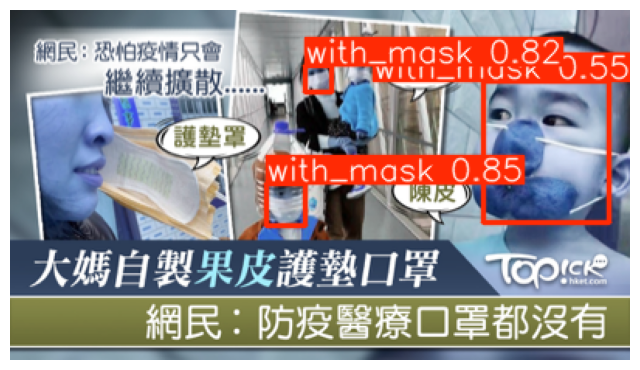


image 1/1 /kaggle/working/data_image/test/maksssksksss806.png: 384x640 5 with_masks, 1 without_mask, 9.5ms
Speed: 1.5ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


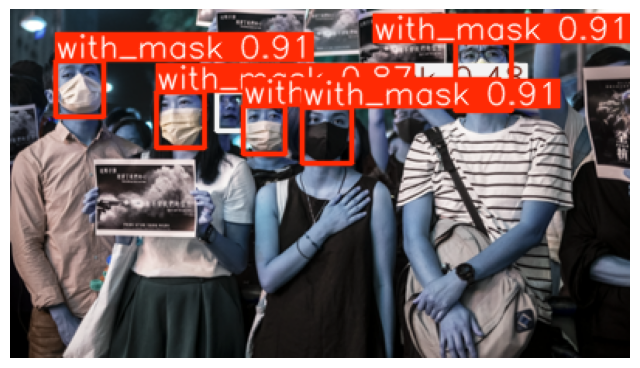


image 1/1 /kaggle/working/data_image/test/maksssksksss577.png: 448x640 11 with_masks, 48.4ms
Speed: 2.2ms preprocess, 48.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


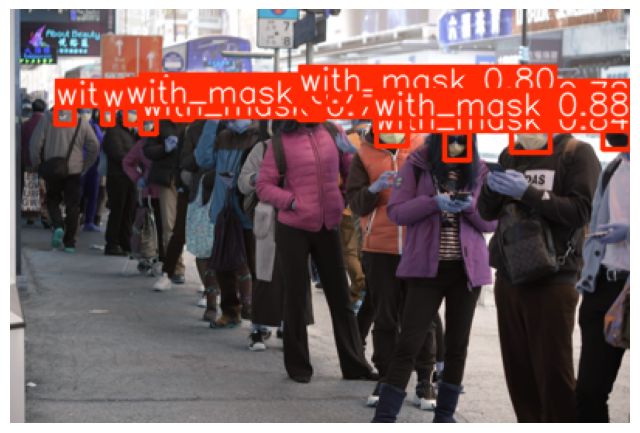


image 1/1 /kaggle/working/data_image/test/maksssksksss580.png: 640x448 1 with_mask, 43.0ms
Speed: 2.1ms preprocess, 43.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


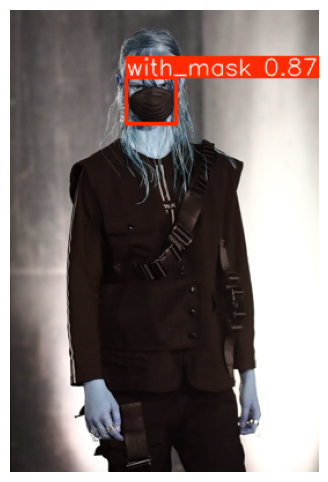


image 1/1 /kaggle/working/data_image/test/maksssksksss837.png: 640x512 1 without_mask, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


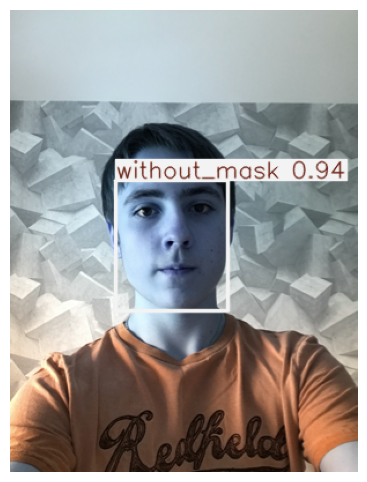


image 1/1 /kaggle/working/data_image/test/maksssksksss398.png: 544x640 1 with_mask, 44.0ms
Speed: 2.1ms preprocess, 44.0ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)


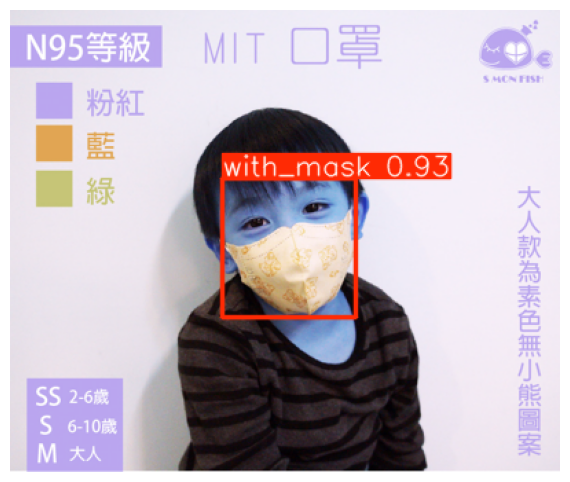


image 1/1 /kaggle/working/data_image/test/maksssksksss106.png: 448x640 1 with_mask, 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


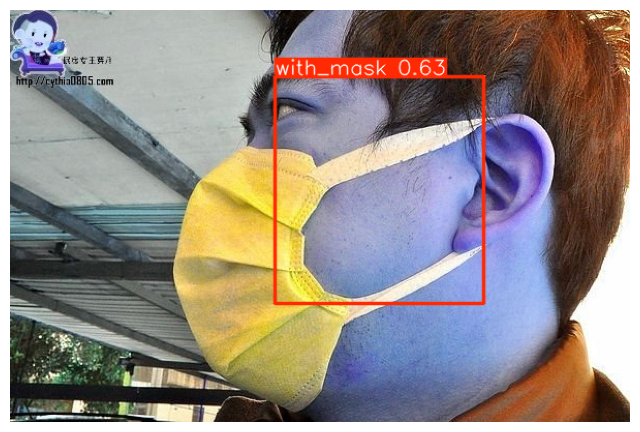


image 1/1 /kaggle/working/data_image/test/maksssksksss333.png: 640x512 1 with_mask, 9.5ms
Speed: 2.4ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


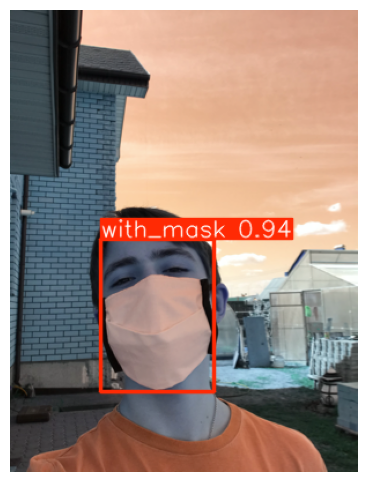


image 1/1 /kaggle/working/data_image/test/maksssksksss181.png: 384x640 2 with_masks, 1 without_mask, 9.8ms
Speed: 1.5ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


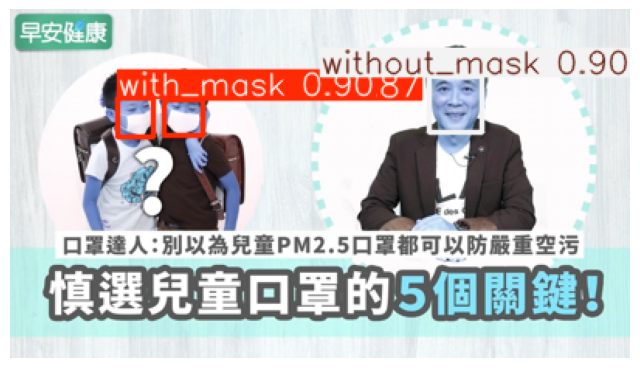


image 1/1 /kaggle/working/data_image/test/maksssksksss125.png: 640x512 1 without_mask, 9.3ms
Speed: 1.9ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


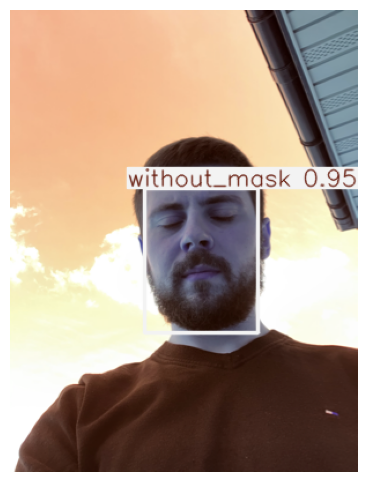

In [35]:
#visualiser les predictions 
image_dir = glob("/kaggle/working/data_image/test/*.png")

selected_images = image_dir[:10]


for img_path in selected_images:
 
    results = model.predict(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    for result in results:
        plotted_img = result.plot()
        plt.figure(figsize=(8, 6))  
        plt.imshow(plotted_img)    
        plt.axis('off')             
        plt.show() 